In [2]:
import torch
from torch import nn
import torchvision

print(f"Pytorch version:{torch.__version__}\n torchvision version:{torchvision.__version__}")

Pytorch version:2.2.1+cu121
 torchvision version:0.17.1+cu121


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(), # 转换为张量
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 归一化
])

# 加载 CIFAR-10 数据集
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 打印数据集大小
print('训练集大小:', len(train_dataset))
print('验证集大小:', len(val_dataset))
print('测试集大小:', len(test_dataset))

# 打印类别标签
classes = dataset.classes
print('类别标签:', classes)

#数据集查看
image, label = train_dataset[0]

# image, label #查看第一条训练数据
image.shape  #查看数据的形状


训练集大小: 40000
验证集大小: 10000
测试集大小: 10000
类别标签: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: (3, 32, 32)


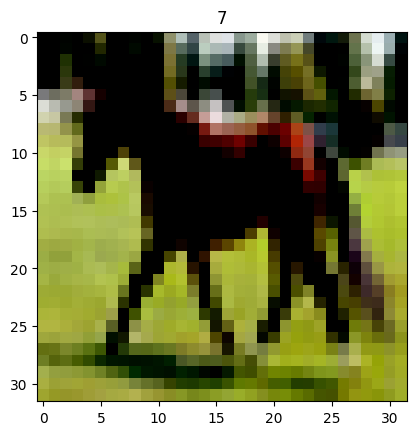

In [4]:
import matplotlib.pyplot as plt
import numpy as np

image, label = train_dataset[0]

# 确保图像数据类型为 NumPy 数组
image = np.array(image)

# 显示图像
print(f"Image shape: {image.shape}")
plt.imshow(image.transpose(1, 2, 0))
plt.title(label)
plt.show()

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [32]:

# 定义模型结构
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(                      # 输入的图片 （3，32，32）
                in_channels=3,
                out_channels=16,            # 经过一个卷积层之后 （16, 32, 32）
                kernel_size=3,
                stride=1,                    # 如果想要 con2d 出来的图片长宽没有变化, padding=(kernel_size-1)/2 当 stride=1 
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)      # 经过池化层处理，维度为（16, 16, 16）
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(                         # 输入（16, 16, 16）
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),                                 # 输出（32,16,16）
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)        # 输出（32,8,8）
        )
        self.out = nn.Linear(32*8*8,10)

    def forward(self, x):
        x = self.conv1(x)                     #（batch_size,16, 16, 16）
        x = self.conv2(x)                     # 输出（batch_size,32, 8, 8）
        x = x.view(x.size(0),-1)              # (batch_size,32*8*8)
        out = self.out(x)                     # (batch_size,10)
        return out

# 定义训练函数
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # 设置模型为训练模式
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # 梯度清零
            outputs = model(inputs)  # 前向传播
            loss = criterion(outputs, labels)  # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 参数更新
            running_loss += loss.item()

        # 打印每个epoch的训练损失
        print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}")

        # 在验证集上评估模型
        model.eval()  # 设置模型为评估模式
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():  # 不计算梯度
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # 打印每个epoch的验证损失和准确率
        print(f"Epoch {epoch+1}, Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {(correct/total)*100:.2f}%")


In [ ]:
from torch.utils.data import DataLoader, random_split

# 设置批处理大小超参数
BATCH_SIZE = 64

# 定义数据加载器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

#打印结果
print(f"Dataloaders: {train_loader, test_loader}")
print(f"Length of 训练集: {len(train_loader)}, batches of {BATCH_SIZE}")
print(f"Length of 验证集: {len(val_loader)}, batches of {BATCH_SIZE}")
print(f"Length of 测试集: {len(test_loader)}, batches of {BATCH_SIZE}")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001914E3B8E90>, <torch.utils.data.dataloader.DataLoader object at 0x000001914E3BB3D0>)
Length of 训练集: 1250, batches of 32
Length of 验证集: 313, batches of 32
Length of 测试集: 313, batches of 32


In [33]:
import torch.optim as optim

# 创建模型实例
model = CNN()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1, Train Loss: 1.444128996038437
Epoch 1, Validation Loss: 1.2137799242053169, Validation Accuracy: 57.53%
Epoch 2, Train Loss: 1.1266274201393127
Epoch 2, Validation Loss: 1.1055989440637655, Validation Accuracy: 61.28%
Epoch 3, Train Loss: 0.9935547696590423
Epoch 3, Validation Loss: 1.0335300147723847, Validation Accuracy: 64.15%
Epoch 4, Train Loss: 0.9106990650892258
Epoch 4, Validation Loss: 0.9893212487903266, Validation Accuracy: 65.68%
Epoch 5, Train Loss: 0.8557869970798493
Epoch 5, Validation Loss: 1.0021116975397348, Validation Accuracy: 64.77%
Epoch 6, Train Loss: 0.8127492791414261
Epoch 6, Validation Loss: 0.9747418660325364, Validation Accuracy: 66.42%
Epoch 7, Train Loss: 0.7771867443323135
Epoch 7, Validation Loss: 0.9767935891120959, Validation Accuracy: 66.82%
Epoch 8, Train Loss: 0.74587426071167
Epoch 8, Validation Loss: 0.9469411765424588, Validation Accuracy: 67.85%
Epoch 9, Train Loss: 0.7196789285182953
Epoch 9, Validation Loss: 0.9514978758443278, Valid

In [ ]:
# 测试集